In [1]:
# Tugas Besar IF3270 Pembelajaran Mesin
# Anggota Kelompok:
# 1. Gede Prasidha Bhawarnawa - 13520004

# Section Tugas Besar A: Implementasi Forward Propagation untuk Feed Forward Neural Network (FFNN)

# Import necessary libraries
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import math
from itertools import islice
import re
import sys

In [2]:
# Softmax Activation Function Implementation
def softmax(arr):
    arr = np.array(arr)
    arr = np.exp(arr)
    sum_arr = np.sum(arr)
    return arr/sum_arr

In [3]:
# Sigmoid Activation Function Implementation
def sigmoid(arr):
    numerator = np.exp(arr)
    denominator = numerator + 1
    return numerator / denominator

In [4]:
# Linear Activation Function Implementation
def linear(arr):
    return arr

In [5]:
# Rectified Linear Unit (ReLU) Activation Function Implementation
def relu(val):
    if val < 0:
        return 0
    else:
        return val

In [6]:
def countSSError(results, expected_results):
    results = np.array(results)
    expected_results = np.array(expected_results)
    if results.shape != expected_results.shape:
        print("Error: array shape mismatch")
        sys.exit(1)
    else:
        return np.sum(np.square(results - expected_results))

In [7]:
# Format for the model input:

# number_of_layers(INT)
# number_of_nodes_in_layer_1(INT)
# number_of_nodes_in_layer_2(INT)
# ...
# number_of_nodes_in_layer_n(INT)
# number_of_output_nodes(INT)
# loop for all nodes except output (
# node_number, node_type, node_level, node_value, activation_function, node_weight_1, node_weight_2, ..., node_weight_n
# )
# Expected output
# Maximum error in the form of sum of squared error (SSE)

# Number of layers doesn't include the input layer and the output layer
# There are four node_types: bias, input, hidden, output
# If the node_type is bias, then the node_value must be 1 or the program will exit with error message. It's activation function doesn't matter
# If the node_type is input, then the node_value must be the input value and the node_level must be 0. It's activation function doesn't matter
# If the node_type is hidden, then the node_value doesn't matter and the node_level must be greater than 0. It's activation function matters
# If the node_type is output, then the node_value doesn't matter and the node_level must be greater than 0. It's activation function matters
# All counts start from 0, including the node_level and node_numbering
# The activation_function must be one of the following: linear, sigmoid, relu, softmax
# The number of node_weights declared in each node must be the same as the number of nodes in the next layer/level
# Note: For each node information, DO NOT USE WHITESPACES

# Example for linear model:

# 0
# 0,bias,0,1,,3:0.2,4:0.3,5:0.1
# 1,input,0,0,,3:0.5,4:0.2,5:-0.8
# 2,input,0,0,,3:0.3,4:-0.6,5:0.4
# 3,output,1,0,linear,
# 4,output,1,0,linear,
# 5,output,1,0,linear,
# [2.0,0.3,-1.9]
# 0.000001

In [8]:
# Node Class and Instances
class Node:
    def __init__(self, node_number, node_type, node_level, activation_function, weight, node_value=0):
        self.node_number = node_number
        self.node_type = node_type
        self.node_value = node_value # For non-input nodes, this value is 0
        self.node_level = node_level
        self.activation_function = activation_function
        self.weight = weight
        self.output = 0
        self.error = 0
    
    def getNodeNumber(self):
        return self.node_number
    
    def getNodeType(self):
        return self.node_type
    
    def getNodeValue(self):
        return self.node_value
    
    def setNodeValue(self, node_value):
        self.node_value = node_value
    
    def getNodeLevel(self):
        return self.node_level
    
    def getActivationFunction(self):
        return self.activation_function
    
    def getActivationFunctionValue(self, value):
        if self.activation_function == "linear":
            return linear(value)
        elif self.activation_function == "sigmoid":
            return sigmoid(value)
        elif self.activation_function == "relu":
            return relu(value)
        else: # Uses softmax
            return softmax(value)
    
    def getWeight(self):
        return self.weight
    
    def getStrWeight(self):
        return str(self.weight)
    
    def getNextLayerNodeNumbers(self, nodes):
        next_layer_nodes = []
        for node in nodes:
            if node.getNodeLevel() == self.node_level + 1:
                next_layer_nodes.append(node.getNodeNumber())
        return next_layer_nodes

In [9]:
class Model:
    def __init__(self, number_of_layers:int, number_of_nodes:int, nodes:list, expected_results:list, max_sse:float):
        self.number_of_layers = number_of_layers
        self.number_of_nodes = number_of_nodes
        self.nodes = nodes # We assume that bias are also nodes of value 1
        self.expected_results = expected_results
        self.max_sse = max_sse
    
    def getNumberOfLayers(self):
        return self.number_of_layers
    
    def getNumberOfNodes(self):
        return self.number_of_nodes
    
    def getNodeList(self):
        return self.nodes
    
    def getNodeByIndex(self, index):
        return self.nodes[index]
    
    def setNodeValueByIndex(self, index, node_value):
        self.nodes[index].setNodeValue(node_value)
    
    def getNodeByLevel(self, layer):
        nodes = []
        for node in self.nodes:
            if node.getNodeLevel() == layer:
                nodes.append(node)
        return nodes
    
    def getExpectedResults(self):
        return self.expected_results
    
    def getMaxSSE(self):
        return self.max_sse

    def getModelInfo(self):
        print("Number of Layers: ", self.number_of_layers)
        print("Number of Nodes: ", self.number_of_nodes) # Bias is also counted as a node here
        print("Nodes: ")
        for node in self.nodes:
            node.getNodeInfo()
    
    def printModelSummary(self):
        print("Model Summary:")
        print("---------------------------------------------------")
        print("{:^10} | {:^10} | {:^10} | {:^10} | {:^10}".format("Node Number", "Node Type", "Layer Depth", "Activation Function", "Weight"))
        for level in range(0,self.number_of_layers+2):
            nodes = self.getNodeByLevel(level)
            for node in nodes:
                print("{:^10d} | {:^10s} | {:^10d} | {:^10s} | {:^10s}".format(
                    node.getNodeNumber(), node.getNodeType(), node.getNodeLevel(), node.getActivationFunction(), node.getStrWeight()))
        print("---------------------------------------------------")
        print("Expected Results: ", str(self.expected_results))
        print("Max SSE: ", self.max_sse)
    
    def getInputNodeNumbers(self):
        input_nodes = []
        for node in self.nodes:
            if node.getNodeLevel() == 0 and node.getNodeType() == "input":
                input_nodes.append(node.getNodeNumber())
        return input_nodes
    
    def getOutputNodeValues(self):
        output_nodes = []
        for node in self.nodes:
            if node.getNodeLevel() == self.number_of_layers + 1:
                output_nodes.append(node.getNodeValue())
        return output_nodes
    
    def printModelVisualization(self):
        edge_list = []
        layer_dict = {}
        for node in self.nodes:
            next_layer_nodes = node.getNextLayerNodeNumbers(self.nodes)
            for next_layer_node in next_layer_nodes:
                if self.getNodeByIndex(next_layer_node).getNodeType() == "bias":
                    pass
                else:
                    edge_pair = (node.getNodeNumber(), next_layer_node)
                    if edge_pair not in edge_list:
                        edge_list.append(edge_pair)
            layer_dict[node.getNodeNumber()] = node.getNodeLevel()
        G = nx.Graph(edge_list)
        nx.set_node_attributes(G, layer_dict, "layer")
        pos = nx.multipartite_layout(G, subset_key="layer", align="vertical")
        nx.draw(G, pos=pos,with_labels=True, node_size=1000, node_color='skyblue', font_size=10, font_color='white', font_weight='bold')
        plt.title("Feed-forward Neural Network Model Representation")
        plt.show()

In [10]:
def readFile(filename):
    nodes =[]
    with open(filename, 'r') as f:
        contents = f.readlines()
        f.close()
    number_of_layers = int(contents[0])
    node_counts = []
    for idx in range(1, number_of_layers+1):
        node_counts.append(int(contents[idx]))
    number_of_nodes = sum(node_counts)
    for idx in range(number_of_layers+1, len(contents) - 2):
        node_info = contents[idx].split(',')
        node_number = int(node_info[0])
        node_type = node_info[1]
        node_level = int(node_info[2])
        node_value = float(node_info[3])
        activation_function = node_info[4]
        # weight = [float(x) for x in node_info[5:]]
        if node_type != 'output':
            weights = {}
            for weight in node_info[5:]:
                weight_info = weight.split(':')
                weights[int(weight_info[0])] = float(weight_info[1])
        else:
            weights = {}
        condition1 = node_type == 'bias' and node_value == 1
        condition2 = node_type == 'input' and node_level == 0
        condition3 = node_type == 'hidden' and node_level > 0
        condition4 = node_type == 'output' and node_level == number_of_layers + 1 
        if condition1 or condition2 or condition3 or condition4:
            nodes.append(Node(node_number, node_type, node_level, activation_function, weights, node_value))
        else:
            print("Invalid node information found in line: ", idx + 1)
            sys.exit(1)
    expected_results = eval(contents[-2])
    max_sse = float(contents[-1])
    result = Model(number_of_layers, number_of_nodes, nodes, expected_results, max_sse)
    # result.getModelInfo()
    result.printModelSummary()
    result.printModelVisualization()
    return result
    

In [11]:
def inferenceData(model_src_name, data_src_name):
    model = readFile(model_src_name)
    # Fill all input nodes with values and then feed the values to the nodes of the next layer
    input_nodes = model.getInputNodeNumbers()
    data = np.genfromtxt(data_src_name, delimiter=',')

    if np.array(data).ndim == 1:
        if len(data) != len(input_nodes):
            print("Number of input nodes and number of features are not equal")
            sys.exit(1)
            
        for idx in range(len(data)):
            model.setNodeValueByIndex(input_nodes[idx], data[idx])

        for layer in range(0, model.getNumberOfLayers()+1):
            # Get all nodes in the layer and then one by one feed the values to the next layer
            # At first the values will be based purely on the node's values and its weights
            # Then it will be passed to the activation function to get the final value
            nodes = model.getNodeByLevel(layer)
            next_node_values = {}
            for node in nodes:
                for next_node_key in node.getWeight().keys():
                    if next_node_key not in next_node_values.keys():
                        next_node_values[next_node_key] = node.getWeight()[next_node_key] * node.getNodeValue()
                    else:
                        next_node_values[next_node_key] += node.getWeight()[next_node_key] * node.getNodeValue()
            isSoftmax = False
            for next_node_key in next_node_values.keys():
                next_node = model.getNodeByIndex(next_node_key)
                next_node_value = next_node_values[next_node_key]
                if next_node.getActivationFunction() != "softmax" and not isSoftmax:
                    isSoftmax = False
                    next_node_value = next_node.getActivationFunctionValue(next_node_value)
                    next_node.setNodeValue(next_node_value)
                    next_node_values[next_node_key] = next_node_value
                else:
                    next_node.setNodeValue(next_node_value)
                    next_node_values[next_node_key] = next_node_value
                    isSoftmax = True
            if isSoftmax:
                # Process all nodes in the layer and then feed the values to that same layer
                process_layer = layer + 1
                nodes = model.getNodeByLevel(process_layer)
                node_numbers_in_order = []
                node_values_in_order = []
                nodes_new_value_pair_key = {}
                for node in nodes:
                    node_numbers_in_order.append(node.getNodeNumber())
                    node_values_in_order.append(node.getNodeValue())
                    nodes_new_value_pair_key[node.getNodeNumber()] = 0
                node_values_in_order = softmax(node_values_in_order)
                for idx in range(len(node_values_in_order)):
                    nodes_new_value_pair_key[node_numbers_in_order[idx]] = node_values_in_order[idx]
                for node in nodes:
                    if node.getNodeNumber() in nodes_new_value_pair_key.keys():
                        node.setNodeValue(nodes_new_value_pair_key[node.getNodeNumber()])
        final_results = model.getOutputNodeValues()
        print("Raw final results: ", [x.tolist() for x in np.array(final_results)])
        # Compare the results with the expected results
        expected_results = model.getExpectedResults()
        print("Expected results: ", expected_results)
        print("Max SSE: ", model.getMaxSSE(), ", SSE: ", countSSError(final_results, expected_results))
        if countSSError(final_results, expected_results) <= model.getMaxSSE():
            print("The model is valid as the error is less than or the same as the maximum SSE")
        else:
            print("The model is invalid as the error is more than the maximum SSE")
    else: # 2 dimensional data
        final_results = []
        for arr in data:
            if len(arr) != len(input_nodes):
                print("Number of input nodes and number of features are not equal")
                sys.exit(1)
                
            for idx in range(len(arr)):
                model.setNodeValueByIndex(input_nodes[idx], arr[idx])

            for layer in range(0, model.getNumberOfLayers()+1):
                # Get all nodes in the layer and then one by one feed the values to the next layer
                # At first the values will be based purely on the node's values and its weights
                # Then it will be passed to the activation function to get the final value
                nodes = model.getNodeByLevel(layer)
                next_node_values = {}
                for node in nodes:
                    for next_node_key in node.getWeight().keys():
                        if next_node_key not in next_node_values.keys():
                            next_node_values[next_node_key] = node.getWeight()[next_node_key] * node.getNodeValue()
                        else:
                            next_node_values[next_node_key] += node.getWeight()[next_node_key] * node.getNodeValue()
                isSoftmax = False
                for next_node_key in next_node_values.keys():
                    next_node = model.getNodeByIndex(next_node_key)
                    next_node_value = next_node_values[next_node_key]
                    if next_node.getActivationFunction() != "softmax" and not isSoftmax:
                        isSoftmax = False
                        next_node_value = next_node.getActivationFunctionValue(next_node_value)
                        next_node.setNodeValue(next_node_value)
                        next_node_values[next_node_key] = next_node_value
                    else:
                        next_node.setNodeValue(next_node_value)
                        next_node_values[next_node_key] = next_node_value
                        isSoftmax = True
                if isSoftmax:
                    # Process all nodes in the layer and then feed the values to that same layer
                    process_layer = layer + 1
                    nodes = model.getNodeByLevel(process_layer)
                    node_numbers_in_order = []
                    node_values_in_order = []
                    nodes_new_value_pair_key = {}
                    for node in nodes:
                        node_numbers_in_order.append(node.getNodeNumber())
                        node_values_in_order.append(node.getNodeValue())
                        nodes_new_value_pair_key[node.getNodeNumber()] = 0
                    node_values_in_order = softmax(node_values_in_order)
                    for idx in range(len(node_values_in_order)):
                        nodes_new_value_pair_key[node_numbers_in_order[idx]] = node_values_in_order[idx]
                    for node in nodes:
                        if node.getNodeNumber() in nodes_new_value_pair_key.keys():
                            node.setNodeValue(nodes_new_value_pair_key[node.getNodeNumber()])
            final_results.append(model.getOutputNodeValues())
        print("Raw final results: ", [x.tolist() for x in np.array(final_results)])
        # Compare the results with the expected results
        expected_results = model.getExpectedResults()
        print("Expected results: ", expected_results)
        print("Max SSE: ", model.getMaxSSE(), ", SSE: ", countSSError(final_results, expected_results))
        if countSSError(final_results, expected_results) <= model.getMaxSSE():
            print("The model is valid as the error is less than or the same as the maximum SSE")
        else:
            print("The model is invalid as the error is more than the maximum SSE")



Model Summary:
---------------------------------------------------
Node Number | Node Type  | Layer Depth | Activation Function |   Weight  
    0      |    bias    |     0      |            | {3: 0.2, 4: 0.3, 5: 0.1}
    1      |   input    |     0      |            | {3: 0.5, 4: 0.2, 5: -0.8}
    2      |   input    |     0      |            | {3: 0.3, 4: -0.6, 5: 0.4}
    3      |   output   |     1      |   linear   |     {}    
    4      |   output   |     1      |   linear   |     {}    
    5      |   output   |     1      |   linear   |     {}    
---------------------------------------------------
Expected Results:  [2.0, 0.3, -1.9]
Max SSE:  1e-06


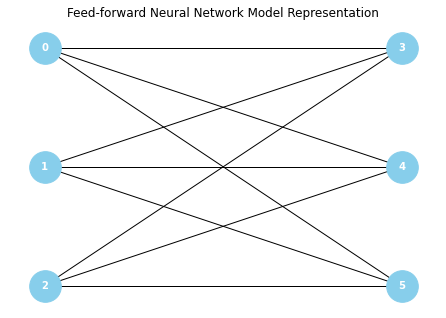

Raw final results:  [2.0, 0.30000000000000016, -1.9000000000000004]
Expected results:  [2.0, 0.3, -1.9]
Max SSE:  1e-06 , SSE:  2.2494861750442915e-31
The model is valid as the error is less than or the same as the maximum SSE


In [12]:
# For linear data and FFNN model
model_src_name = "linearModel.txt"
data_src_name = "linearData.csv"
inferenceData(model_src_name, data_src_name)

Model Summary:
---------------------------------------------------
Node Number | Node Type  | Layer Depth | Activation Function |   Weight  
    0      |    bias    |     0      |            | {3: 0.1, 4: 0.2, 5: 0.3}
    1      |   input    |     0      |            | {3: 0.4, 4: -0.5, 5: 0.6}
    2      |   input    |     0      |            | {3: 0.7, 4: 0.8, 5: -0.9}
    3      |   output   |     1      |    relu    |     {}    
    4      |   output   |     1      |    relu    |     {}    
    5      |   output   |     1      |    relu    |     {}    
---------------------------------------------------
Expected Results:  [0.05, 1.1, 0.0]
Max SSE:  1e-06


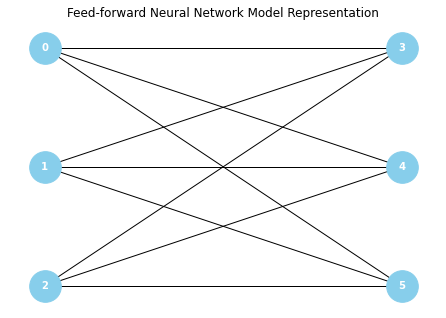

Raw final results:  [0.04999999999999993, 1.1, 0.0]
Expected results:  [0.05, 1.1, 0.0]
Max SSE:  1e-06 , SSE:  4.8148248609680896e-33
The model is valid as the error is less than or the same as the maximum SSE


In [13]:
# For ReLU data and FFNN model
model_src_name = "reluModel.txt"
data_src_name = "reluData.csv"
inferenceData(model_src_name, data_src_name)

Model Summary:
---------------------------------------------------
Node Number | Node Type  | Layer Depth | Activation Function |   Weight  
    0      |    bias    |     0      |            | {3: 0.4, 4: 0.2, 5: 0.1}
    1      |   input    |     0      |            | {3: 0.2, 4: 0.4, 5: 0.2}
    2      |   input    |     0      |            | {3: 0.1, 4: 0.2, 5: 0.4}
    3      |   output   |     1      |  sigmoid   |     {}    
    4      |   output   |     1      |  sigmoid   |     {}    
    5      |   output   |     1      |  sigmoid   |     {}    
---------------------------------------------------
Expected Results:  [0.617747, 0.58904, 0.574442]
Max SSE:  1e-06


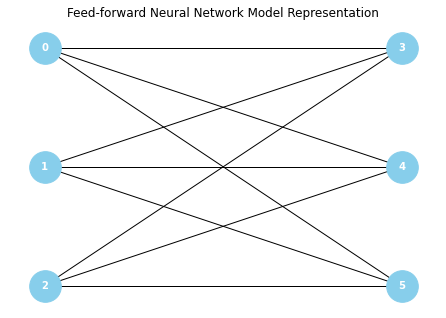

Raw final results:  [0.617747874769249, 0.5890404340586651, 0.574442516811659]
Expected results:  [0.617747, 0.58904, 0.574442]
Max SSE:  1e-06 , SSE:  1.2207224545374987e-12
The model is valid as the error is less than or the same as the maximum SSE


In [14]:
# For sigmoid data and FFNN model
model_src_name = "sigmoidModel.txt"
data_src_name = "sigmoidData.csv"
inferenceData(model_src_name, data_src_name)

Model Summary:
---------------------------------------------------
Node Number | Node Type  | Layer Depth | Activation Function |   Weight  
    0      |    bias    |     0      |            | {3: 1.0, 4: 2.0, 5: 3.0}
    1      |   input    |     0      |            | {3: 2.0, 4: 1.0, 5: 3.0}
    2      |   input    |     0      |            | {3: 3.0, 4: 2.0, 5: 1.0}
    3      |   output   |     1      |  softmax   |     {}    
    4      |   output   |     1      |  softmax   |     {}    
    5      |   output   |     1      |  softmax   |     {}    
---------------------------------------------------
Expected Results:  [0.665241, 0.090031, 0.244728]
Max SSE:  1e-06


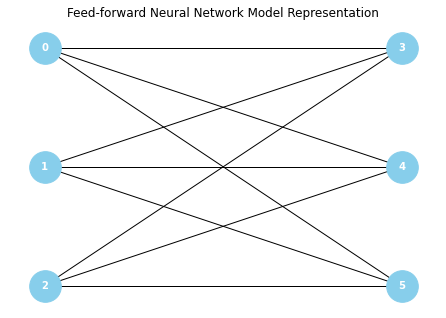

Raw final results:  [0.6652409557748219, 0.09003057317038045, 0.24472847105479764]
Expected results:  [0.665241, 0.090031, 0.244728]
Max SSE:  1e-06 , SSE:  4.0603201288236806e-13
The model is valid as the error is less than or the same as the maximum SSE


In [15]:
# For softmax data and FFNN model
model_src_name = "softmaxModel.txt"
data_src_name = "softmaxData.csv"
inferenceData(model_src_name, data_src_name)

Model Summary:
---------------------------------------------------
Node Number | Node Type  | Layer Depth | Activation Function |   Weight  
    0      |    bias    |     0      |            | {4: 0.5, 5: 0.5}
    1      |   input    |     0      |            | {4: 0.0, 5: -2.0}
    2      |   input    |     0      |            | {4: -1.0, 5: 0.0}
    3      |    bias    |     1      |            | {6: 0.5, 7: 0.5}
    4      |   hidden   |     1      |   linear   | {6: 0.0, 7: -3.0}
    5      |   hidden   |     1      |   linear   | {6: -1.0, 7: 0.0}
    6      |   output   |     2      |    relu    |     {}    
    7      |   output   |     2      |    relu    |     {}    
---------------------------------------------------
Expected Results:  [[2.0, 0.0], [0.0, 2.0], [0.0, 0.0]]
Max SSE:  1e-06


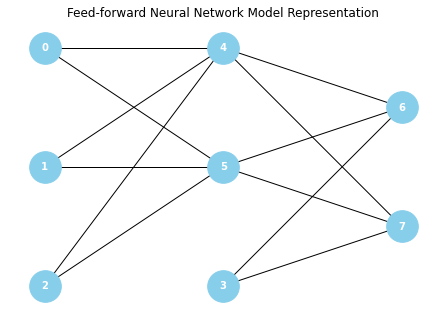

Raw final results:  [[2.0, 0.0], [0.0, 2.0], [0.0, 0.0]]
Expected results:  [[2.0, 0.0], [0.0, 2.0], [0.0, 0.0]]
Max SSE:  1e-06 , SSE:  0.0
The model is valid as the error is less than or the same as the maximum SSE


In [16]:
# For multilayer data and FFNN model
model_src_name = "multilayerModel.txt"
data_src_name = "multilayerData.csv"
inferenceData(model_src_name, data_src_name)